### pip install missingno

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz, plot_tree
from sklearn import tree
import graphviz
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import six
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from numpy import absolute
from imblearn.over_sampling import SMOTE
import impyute as impy
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.metrics import mean_squared_error
import missingno as msno


# Constantes

In [2]:
TESTE_SIZE_30 = 0.3
TESTE_SIZE_25 = 0.25
TESTE_SIZE_20 = 0.2
RANDOM_SEED = 42
TEST_MONTE_CARLO = 10
DATA_SIZE = 1500
RESULTS = {
    "Algoritmo": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}
COLUNMS = ['ph','Sulfate', 'Turbidity', 'Conductivity']
ALL_COLUMNS = ['ph','Hardness','Solids', 'Chloramines', 'Sulfate', 
               'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity',
                'Potability']

# Funções Auxiliares

In [3]:
def expectation_maximization_to_data_frame(df, columns):
    df_em_imputed = impy.em(df.values)
    return pd.DataFrame(df_em_imputed, columns=columns)

In [4]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [5]:
def smote_balance(X, y):
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    return X, y

In [6]:
def standardize_data(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=list(df.columns))

In [7]:
def normalize_data(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=list(df.columns))

In [8]:
def knn_imputer(df):
    imputer = KNNImputer(n_neighbors=5)
    return pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

## Lidar com outliers

In [9]:
def outlier_limits(df, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_limits(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit
    
def replace_with_mean(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = df[variable].mean()
    df.loc[(df[variable] > up_limit), variable] = df[variable].mean()

def replace_with_median(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = df[variable].median()
    df.loc[(df[variable] > up_limit), variable] = df[variable].median()

def remove_iqr_outliers(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = np.nan
    df.loc[(df[variable] > up_limit), variable] = np.nan
    
def remove_outliers_iqr(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    data = data.select_dtypes(include=numerics)

    for i in data.columns:
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        IQR = Q3 - Q1
    
        data = data[~((data[i] < (Q1 - 1.5 * IQR)) | (data[i] > (Q3 + 1.5 * IQR)))]

    return data

In [10]:
def simple_imputer_median(X_train, X_test):
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    return X_train, X_test

In [11]:
def min_max_values(df):
    for index in df.columns:
        print(f'{index} - min: {df[index].min()}, max:{df[index].max()}')

In [12]:
def exclude_duplicated(data):
    return data.drop_duplicates()

In [13]:
def remove_outliers(dados):
    z = np.abs(stats.zscore(dados))
    return dados[(z<3).all(axis=1)]

In [14]:
def plot_conf():
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Especificidade(Taxa de Falso Positivo)')
    plt.ylabel('Sensibilidade(Taxa de Verdadeiro Positivo)')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()   # Display

In [15]:
def plot_dt_graph(X, modelo):
    features = X.columns
    dot_data = export_graphviz(modelo, out_file=None, 
                               filled = True, rounded = True,
                               feature_names=features,
                               class_names = ['não', 'sim'])
    grafico = graphviz.Source(dot_data)
    
    return grafico

In [16]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], Edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(Edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
            
    return ax

## Recuperando os modelos

In [17]:
def models_dict():
    models = {
        'LR': make_pipeline(StandardScaler(), LogisticRegression(C=0.44, max_iter=500, solver='liblinear', penalty='l2')),
        'NB': make_pipeline(StandardScaler(), GaussianNB()),
        'SVM': make_pipeline(StandardScaler(), SVC(C=5, degree=1,gamma=0.1,kernel='rbf',probability=True)),
        'RF': make_pipeline(RandomForestClassifier(criterion='gini', max_depth=10, 
                                                   min_samples_leaf=1, min_samples_split=2, n_estimators=200)),
        'MLP': make_pipeline(StandardScaler(), MLPClassifier(max_iter=800)),
        'DT': make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=6, criterion='gini'))
    }
    
    return models

## Avaliando os modelos

In [18]:
def evaluate_model(models, X_train, X_test, y_train, y_test):
    scores = list()
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred),3)
        y_prob = model.predict_proba(X_test)[:,1]
        false_positive, true_positive, threshold = roc_curve(y_test, y_prob)  
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append(acc)
        auc = round(roc_auc_score(y_test, model.predict(X_test)),3)
        RESULTS['Algoritmo'].append(name)
        RESULTS['Acurácia'].append(acc)
        RESULTS['F1_score'].append(round(report['macro avg']['f1-score'], 3))
        RESULTS['Taxa_VP'].append(round(report['macro avg']['recall'], 3))
        RESULTS['Precisão'].append(round(report['macro avg']['precision'], 3))
        RESULTS['AUC'].append(auc)
        #plt.plot(false_positive, true_positive, label='%s ROC (AUC = %0.4f)' % (name, auc))
        plot_feature_importance(model.feature_importances_, X_train.columns, name)
    #plot_conf()
    
    return pd.DataFrame(RESULTS), scores, model

## Plotando Matriz de confusão

In [19]:
def plot_cm_one_by_one(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        disp = ConfusionMatrixDisplay.from_estimator(model,X_test, y_test, colorbar=False)
        disp.ax_.set_title(name)
        plt.grid(False)
    plt.show()

In [20]:
def plot_all_cm(classifiers, X_train, X_test, y_train, y_test):
    f, axes = plt.subplots(1, 2, figsize=(20, 6), sharey='row')
    for i, (key, classifier) in enumerate(classifiers.items()):
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        disp.ax_.grid(False)
        
        if i!=0:
            disp.ax_.set_ylabel('')
    
    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

# Importando os dados

In [21]:
# Carregamento do banco de dados
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')

df.shape

(3276, 10)

# Análise da base de dados

## Verificando valores nulos

In [22]:
def contar_valores_faltantes(dados):
    total_faltantes = dados.isna().sum()
    return total_faltantes

# Exemplo de uso:
valores_faltantes = contar_valores_faltantes(df)
print(valores_faltantes)

total_faltantes = valores_faltantes.sum()
print(f'Total de valores faltantes: {total_faltantes}')

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
Total de valores faltantes: 1434


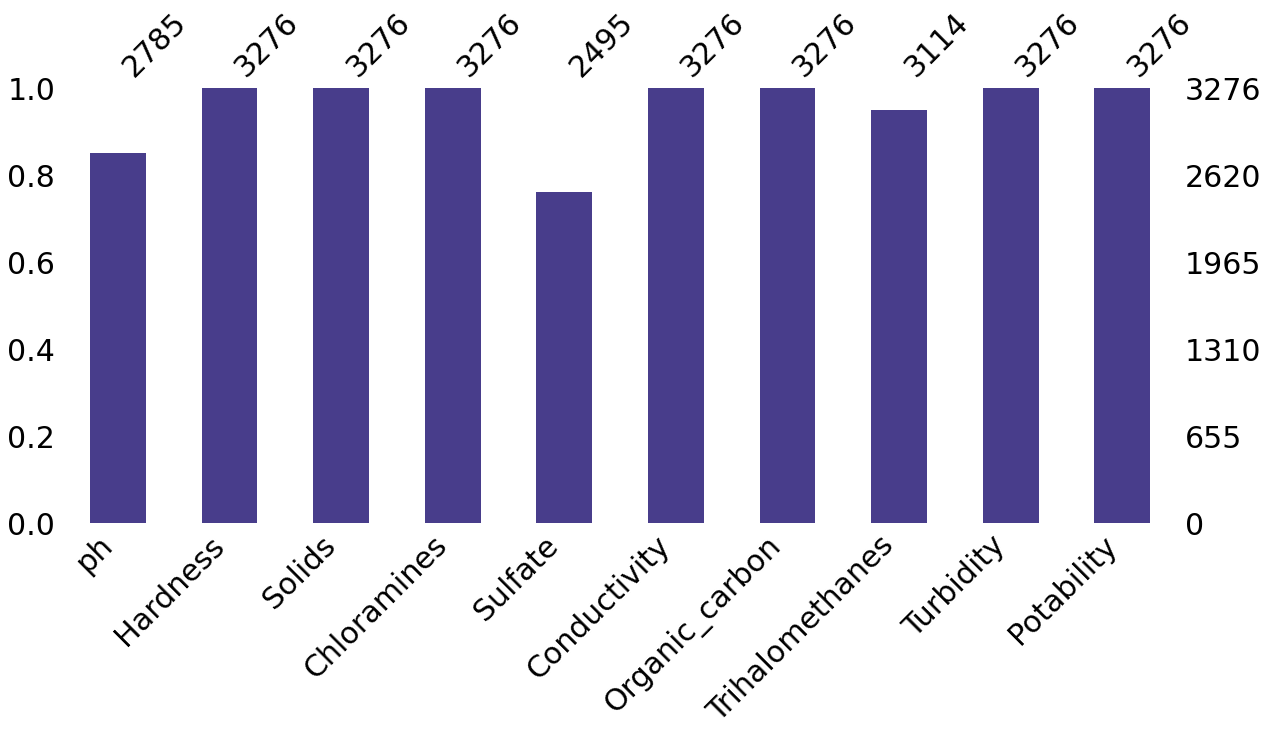

In [23]:
msno.bar(df, figsize = (20,8),color = "#483D8B", fontsize=30)
plt.show()

## Balanceamento do desfecho

In [24]:
counter = Counter(df["Potability"].map({0:'NP',1:'P'}))
print(counter)

Counter({'NP': 1998, 'P': 1278})


Text(0.8, 1500, 'Safe for Human consumption')

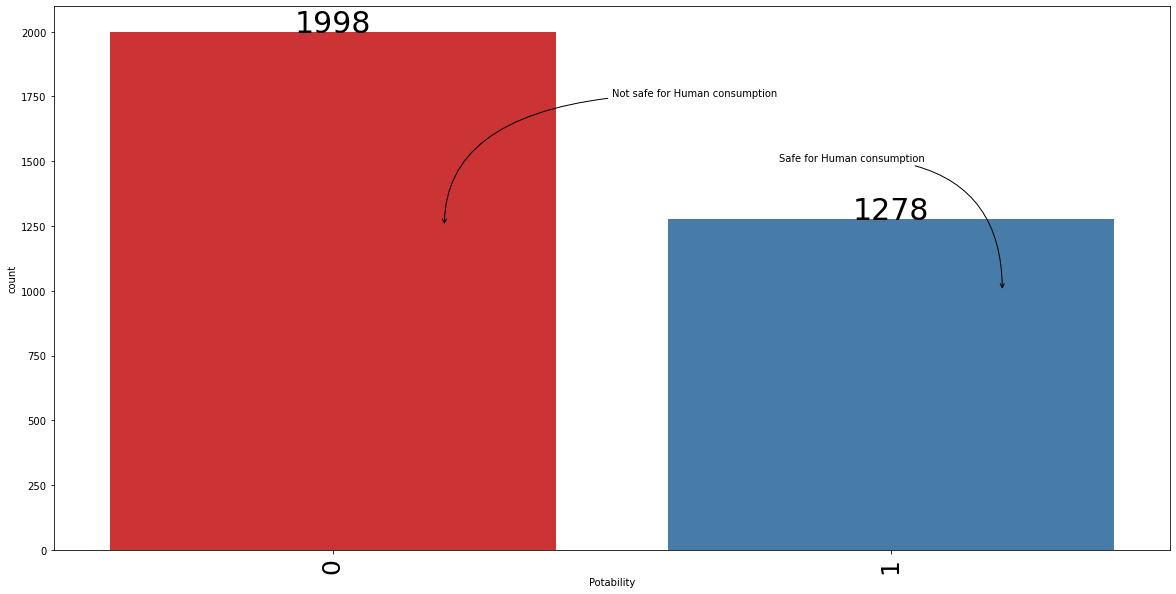

In [25]:
fig, ax1 = plt.subplots(figsize=(20,10))
graph = sns.countplot(ax=ax1,x = 'Potability', data = df, palette='Set1')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90, fontsize=25)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center", fontsize=30)

plt.grid(False)
plt.annotate(text="Not safe for Human consumption", xytext=(0.5,1750),xy=(0.2,1250), arrowprops =dict(arrowstyle="->", color='black', connectionstyle="angle3,angleA=0,angleB=90"), color='black')
plt.annotate(text="Safe for Human consumption", xytext=(0.8,1500),xy=(1.2,1000), arrowprops =dict(arrowstyle="->", color='black',  connectionstyle="angle3,angleA=0,angleB=90"), color='black')

# Outliers

In [26]:
def contar_outliers_iqr(dados, colunas):
    total_outliers = 0
    
    for coluna in colunas:
        Q1 = dados[coluna].quantile(0.25)
        Q3 = dados[coluna].quantile(0.75)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        outliers_coluna = dados[(dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)]
        
        total_outliers += len(outliers_coluna)
    
    return total_outliers

# Exemplo de uso:
total_outliers = contar_outliers_iqr(df, ALL_COLUMNS)
print(f'Total de outliers encontrados: {total_outliers}')

Total de outliers encontrados: 366


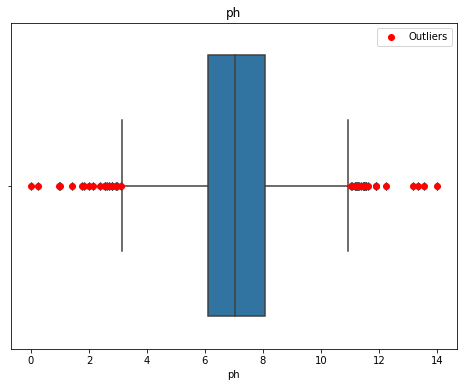

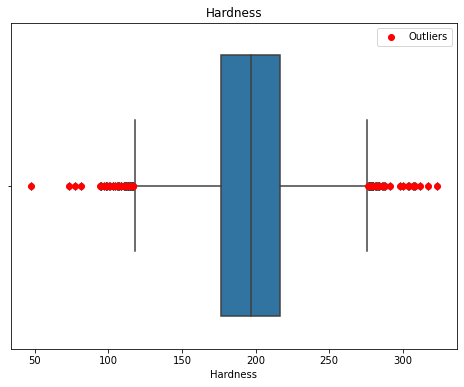

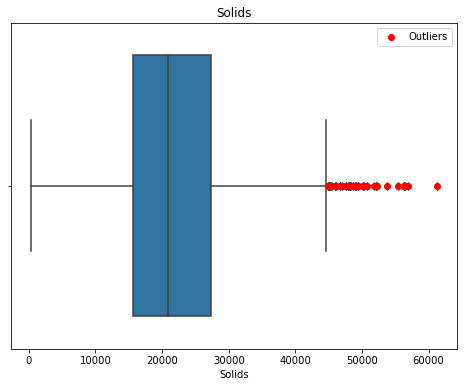

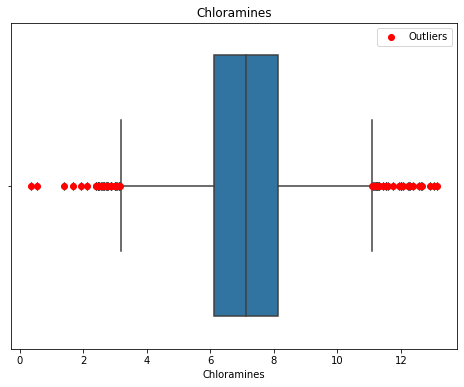

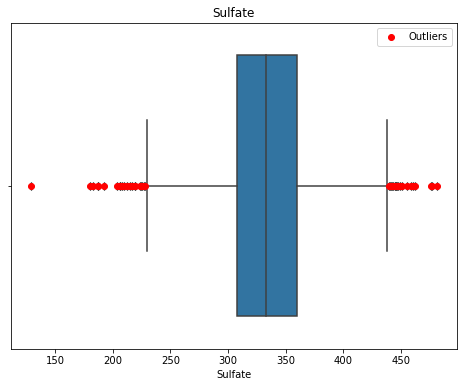

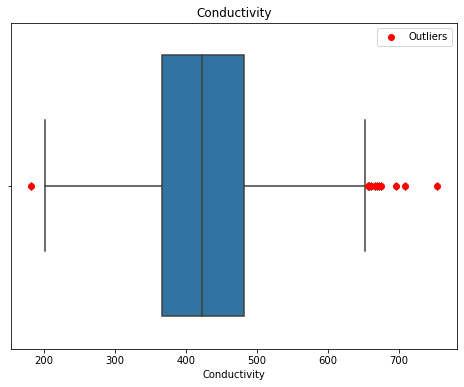

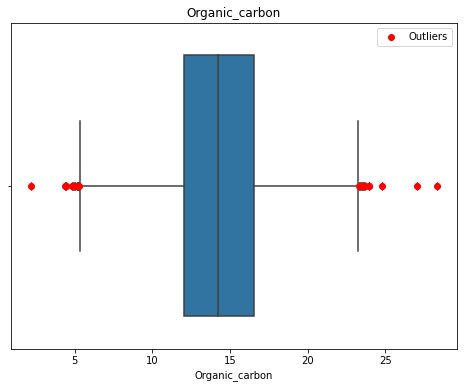

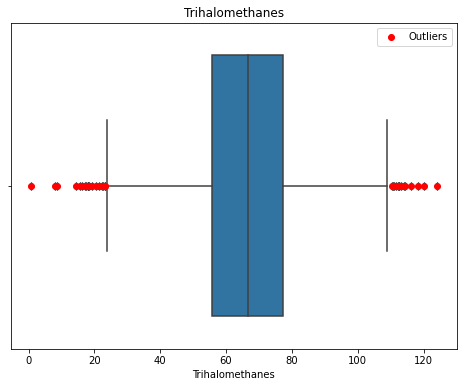

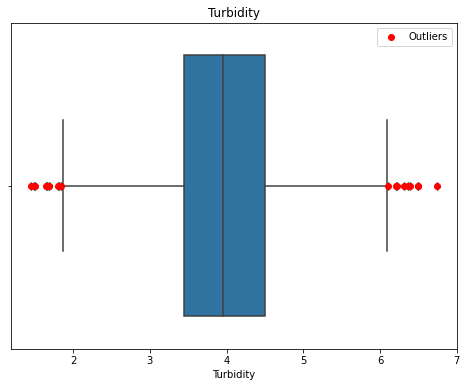

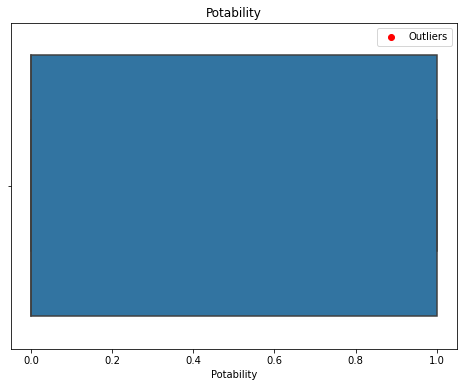

In [27]:
def plotar_boxplot_com_outliers(dados, colunas):
    for coluna in colunas:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=dados[coluna], orient='h')
        plt.title(f'{coluna}')
        
        # Adiciona marcadores para os outliers
        outliers = dados[(dados[coluna] < dados[coluna].quantile(0.25) - 1.5 * (dados[coluna].quantile(0.75) - dados[coluna].quantile(0.25))) |
                         (dados[coluna] > dados[coluna].quantile(0.75) + 1.5 * (dados[coluna].quantile(0.75) - dados[coluna].quantile(0.25)))]
        plt.scatter(outliers[coluna], [0] * len(outliers), color='red', label='Outliers', zorder=5)
        
        plt.legend()
        plt.show()

# Exemplo de uso:
plotar_boxplot_com_outliers(df, ALL_COLUMNS)

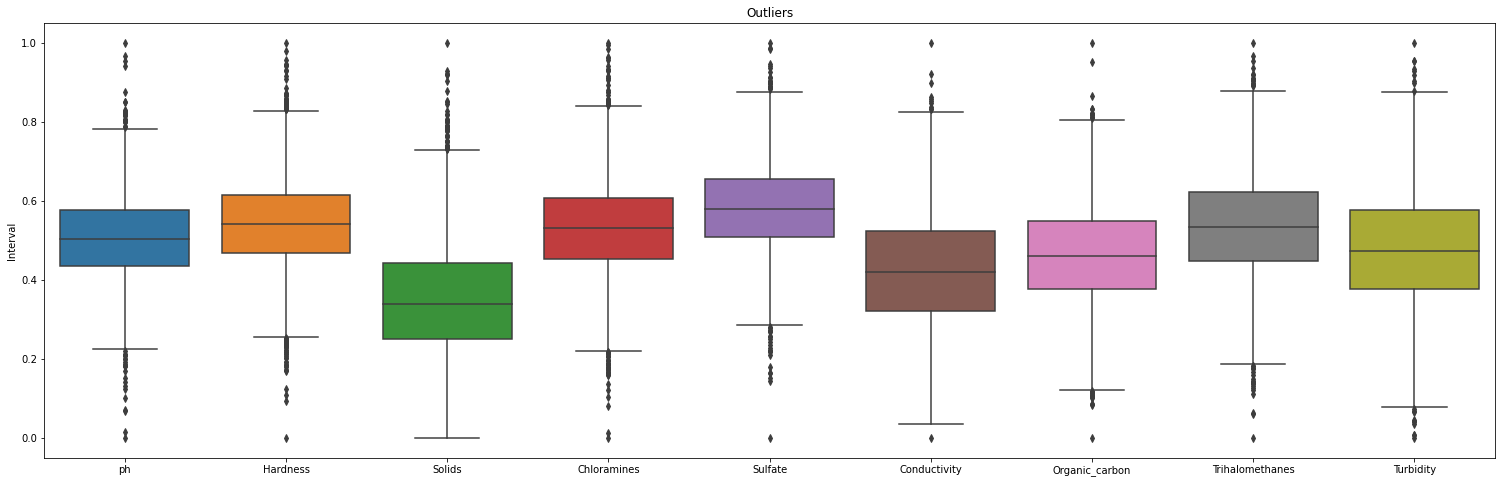

In [28]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df_without = df.drop('Potability', axis = 1)
df_norm = normalize_data(df_without)

plt.figure(figsize=(26, 8))

# Criando o boxplot com Seaborn
sns.boxplot(data=df_norm)

# Exibindo o gráfico
plt.title('Outliers')
plt.ylabel('Interval')
plt.show()

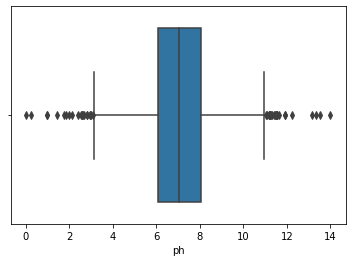

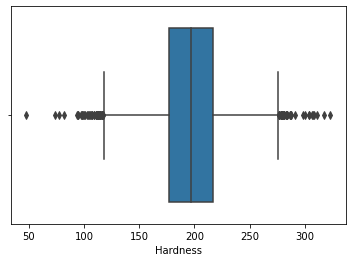

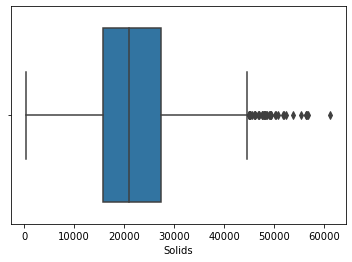

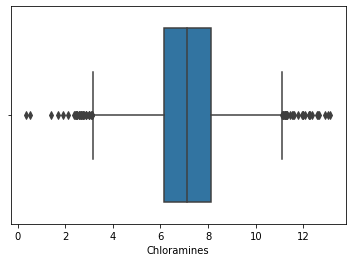

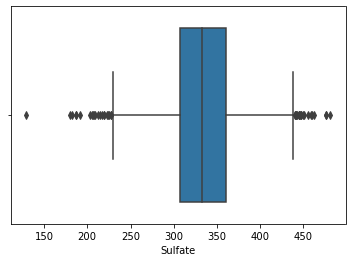

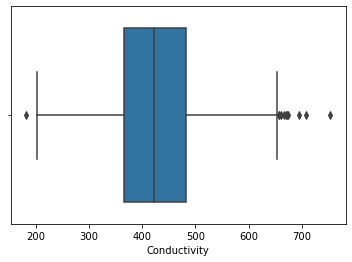

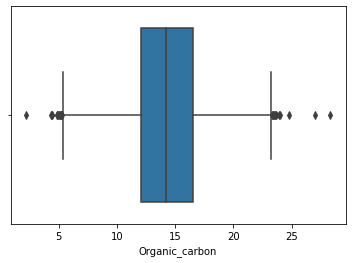

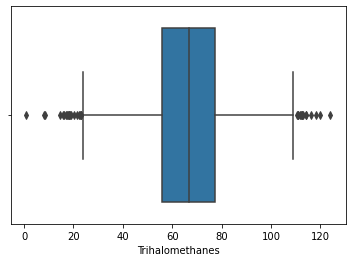

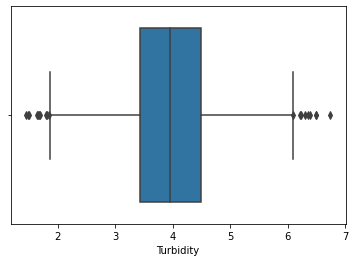

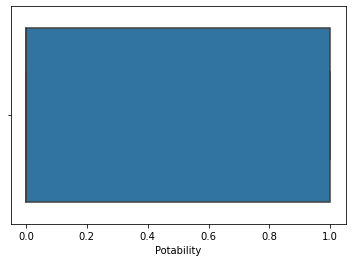

In [29]:
cols = list(df.columns)
for item in cols:     
    sns.boxplot(x = df[item])
    plt.show()

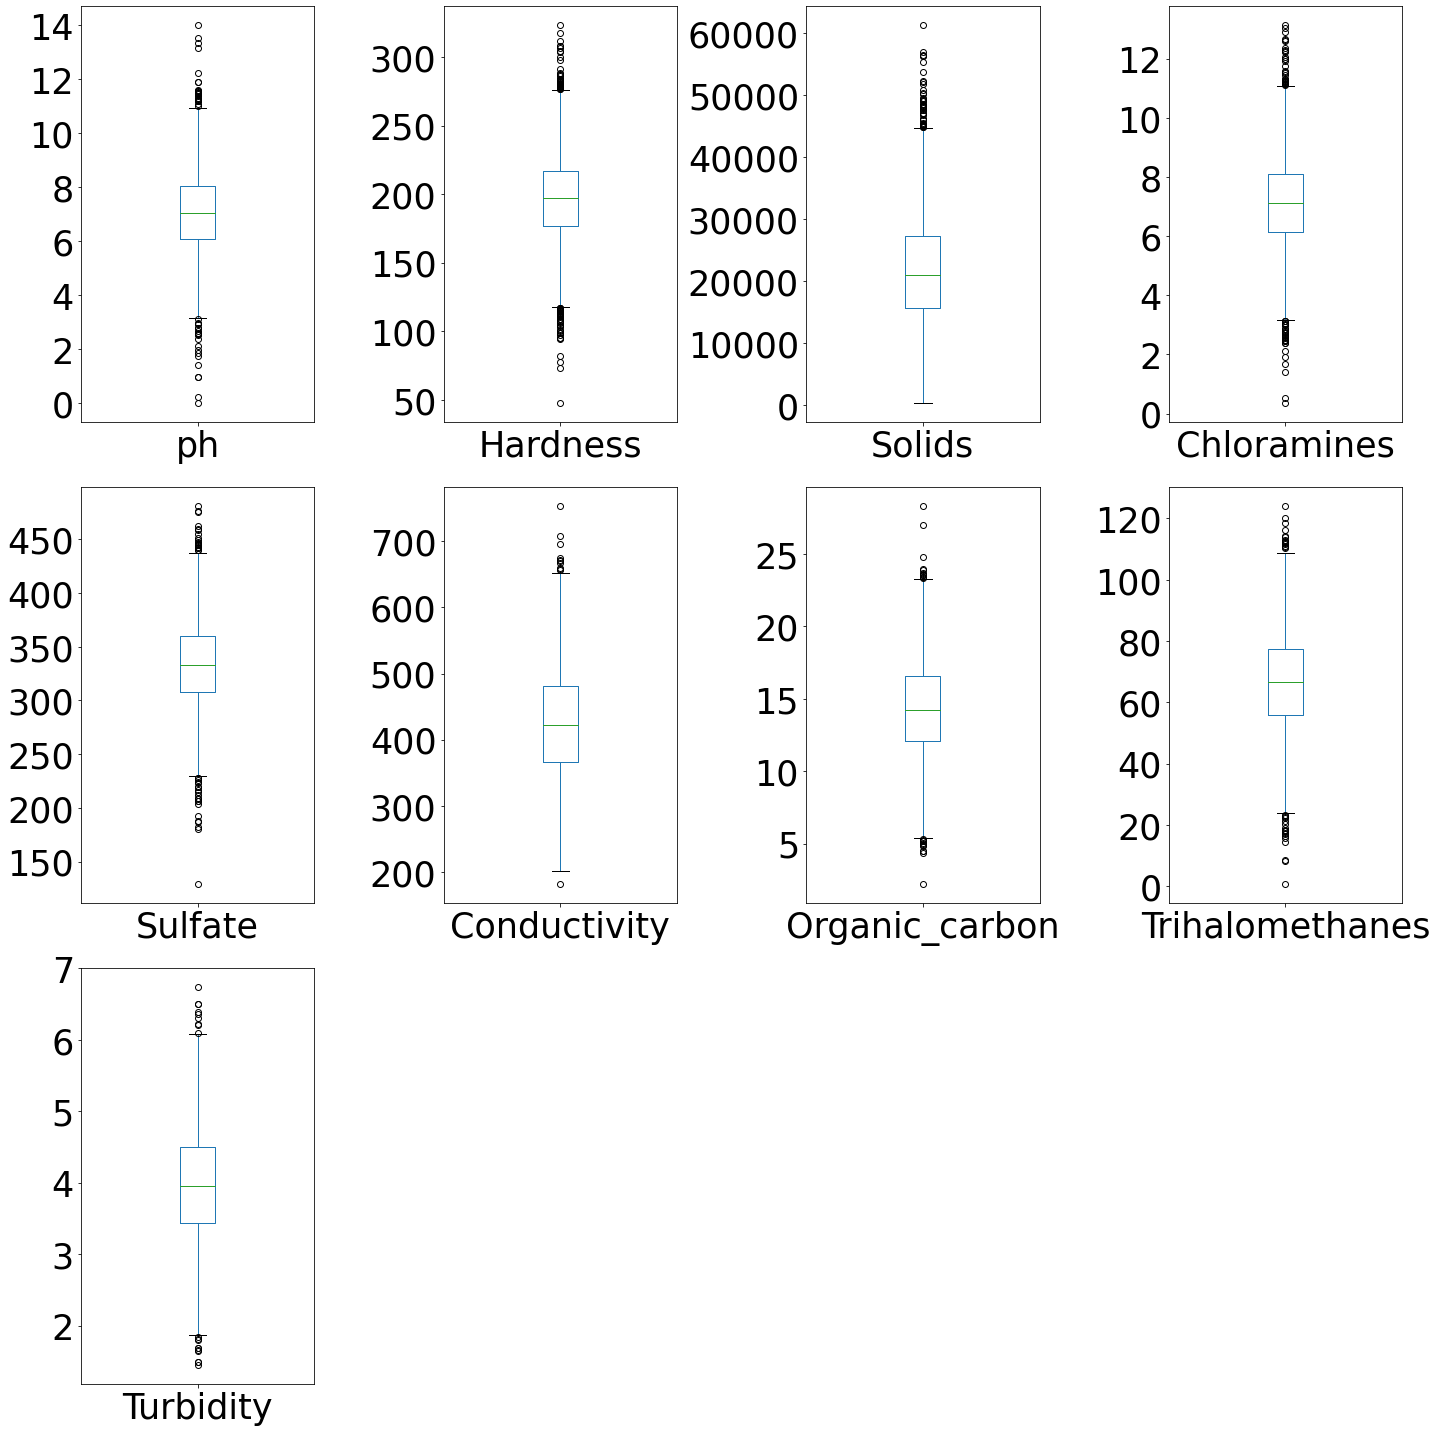

In [30]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df_without = df.drop('Potability', axis = 1)
df_without.plot(kind = "box",
                layout = (3,4),
                subplots = True,
                figsize = (20,20),
                fontsize=35)

plt.tight_layout()
plt.show()

## Distribuição dos atributos

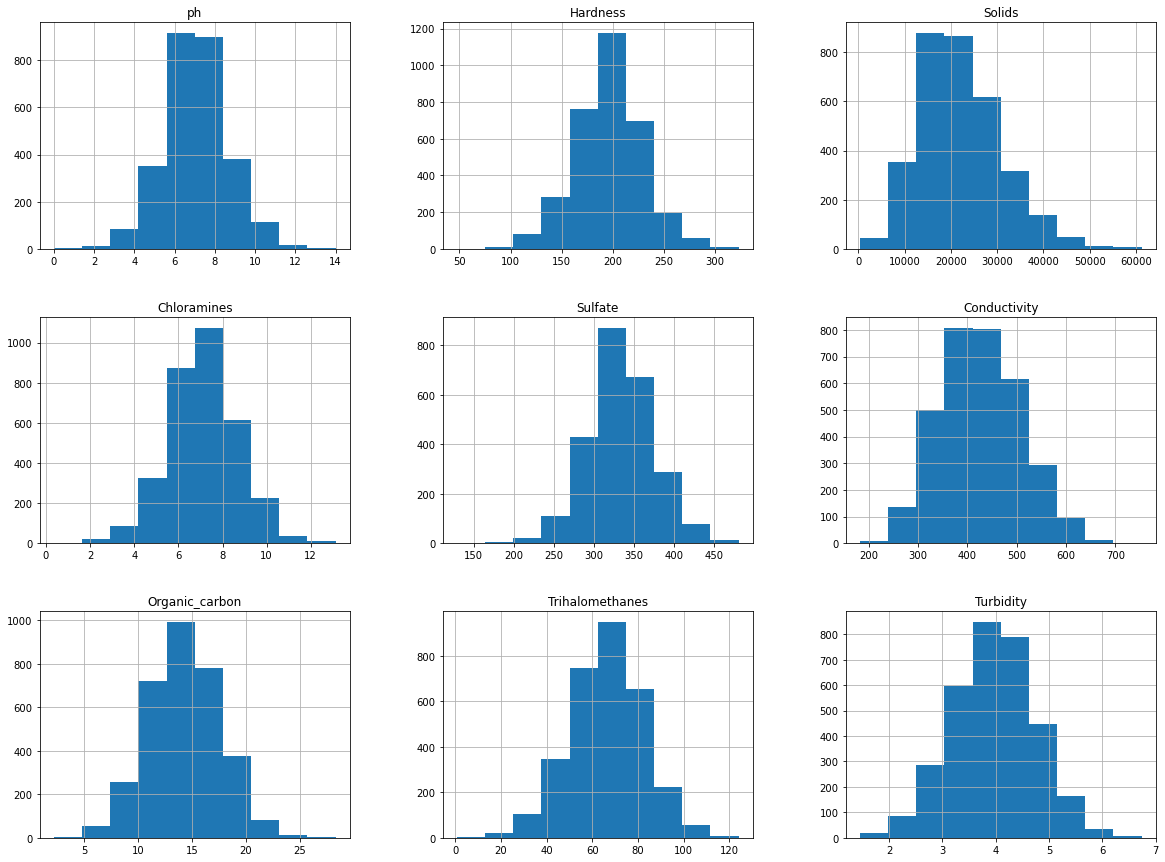

In [31]:
df_without.hist(figsize=(20,15))
plt.show()

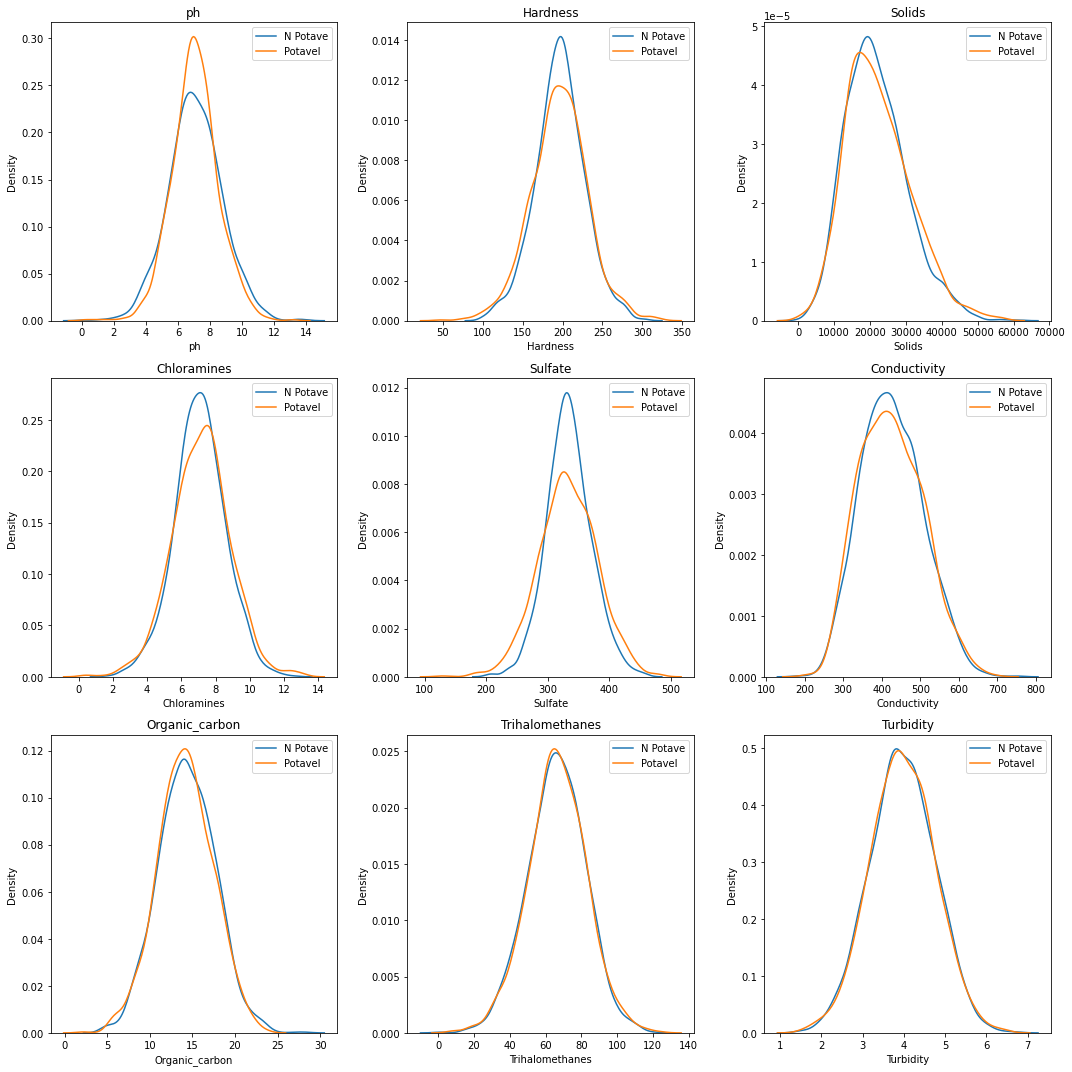

In [32]:
not_drinkable = df[df['Potability']==0]
drinkable  = df[df['Potability']==1]
plt.figure(figsize = (15,15))
for i, col in enumerate(df.columns[:9]):
    plt.subplot(3,3, i+1)
    plt.title(col)
    sns.kdeplot(x = not_drinkable[col], label = "N Potave")
    sns.kdeplot(x = drinkable[col], label = "Potavel")
    plt.legend()
plt.tight_layout()

# Correlacionados

<AxesSubplot:>

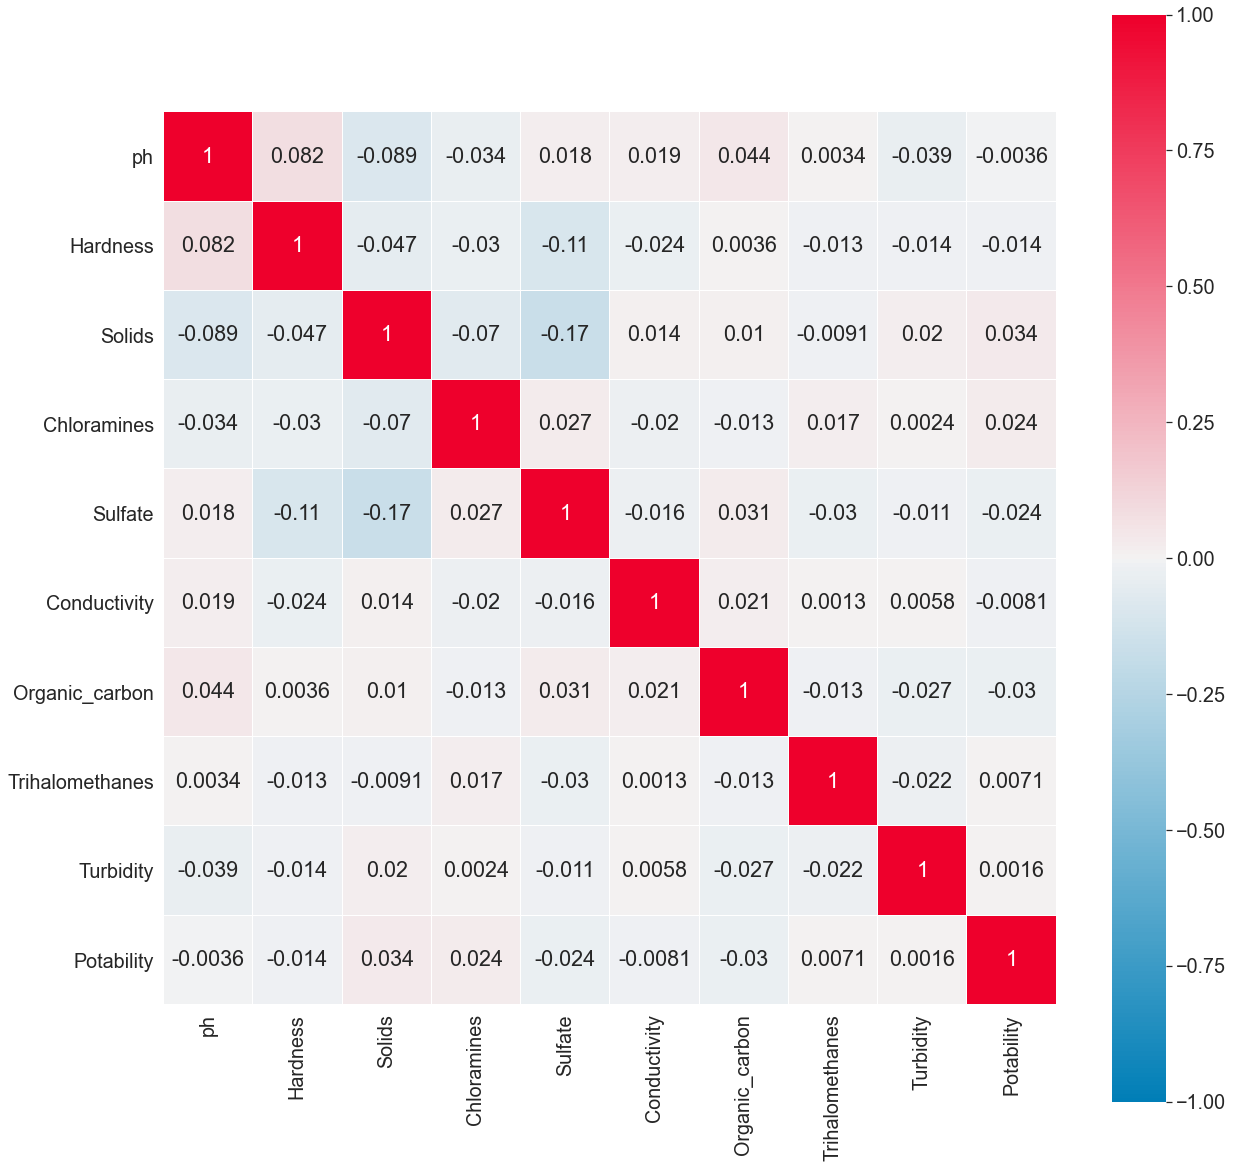

In [33]:
corr_matrix = df.corr(method='pearson')
plt.figure(figsize= (20,20))
sns.set(font_scale=1.8)

cmap = sns.diverging_palette(
    h_neg=240,
    h_pos=10,
    s=100,
    as_cmap=True,
)
sns.heatmap(
    corr_matrix,
    cmap=cmap,
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.01,
    annot=True
)

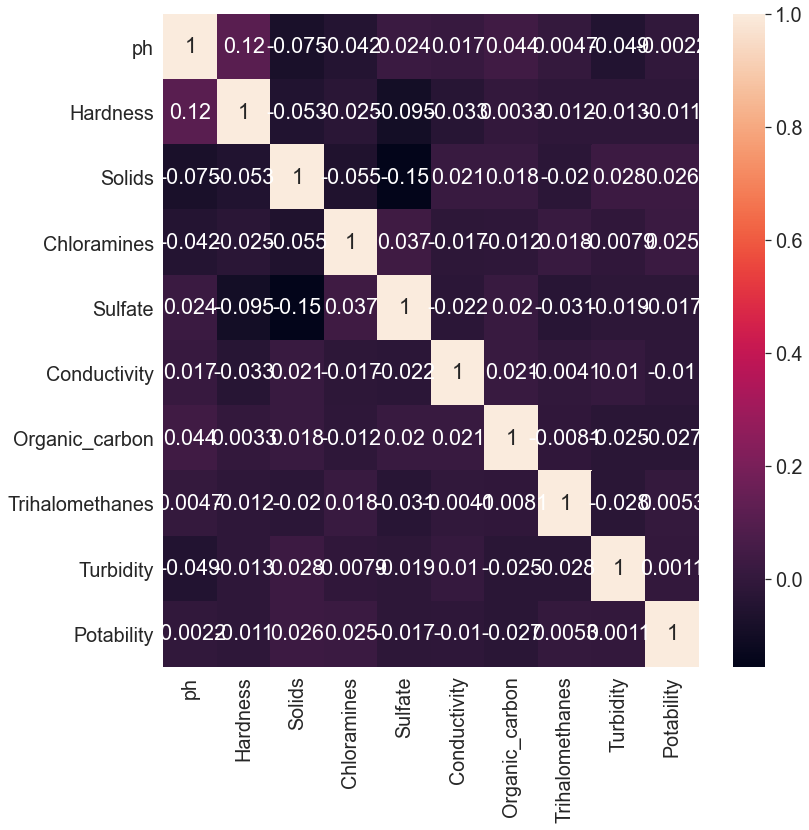

In [34]:
corr = df.corr(method='spearman')
plt.figure(figsize= (12,12))
sns.heatmap(corr, annot = True);

# Transformação dos dados

In [35]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [36]:
df = normalize_data(df)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,NaN,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,NaN,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0


# Implementação dos modelos

## Funções

In [37]:
def expectation_maximazation_to_data_frame(df, columns):
    df_em_imputed = impy.em(df.values)
    return pd.DataFrame(df_em_imputed, columns=columns)

## Resultados - 80% Treinamento e 20% Teste

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
def get_X_chi2_feature(X, n_components=100):
    chi2_feature = SkewedChi2Sampler(skewedness=.01, n_components=n_components, random_state=RANDOM_SEED)
    
    return chi2_feature.fit_transform(X, y)

In [40]:
def evaluate_model_with_smote_chi2(models, X, y, result, treatment):
    X, y = smote_balance(X, y)
    X = get_X_chi2_feature(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TESTE_SIZE_20, random_state=RANDOM_SEED)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred), 3)
        y_prob = model.predict_proba(X_test)[:,1]
        false_positive, true_positive, threshold = roc_curve(y_test, y_prob)  
        report = classification_report(y_test, y_pred, output_dict=True)
        auc = round(roc_auc_score(y_test, model.predict(X_test)), 3)
        result['model'].append(name)
        result['treatment'].append(treatment)
        result['acc'].append(acc)
        #result['f1_score'].append(round(report['macro avg']['f1-score'], 3))
        #result['recall'].append(round(report['macro avg']['recall'], 3))
        result['precision'].append(round(report['macro avg']['precision'],3))
        #result['rmse'].append(round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 3))
        result['auc'].append(auc)
        #plt.plot(false_positive, true_positive, label='%s ROC (AUC = %0.4f)' % (name, auc))
    #plot_conf()
    
    #render_mpl_table(pd.DataFrame(result).sort_values(by=['acc'], ascending=False))
    #plot_all_cm(models, X_train, X_test, y_train, y_test)
    
    return pd.DataFrame(result)

### Configurações de pré-processamento

In [41]:
results = {
    "model": [],
    "treatment": [],
    "acc": [],
    #"rmse": [],
    "precision": [],
    #"recall": [],
    #"f1_score": [],
    "auc": []
}

# 1 a 4
RRNS = 'RRNS'
RMNS = 'RMNS'
RMNNS = 'RMNNS'
RSVLISNS = 'RSVLISNS'

# 5 a 8
MRNS = 'MRNS'
MMNS = 'MMNS'
MMNNS = 'MMNNS'
MSVLISNS = 'MSVLISNS'

# 9 a 12
MNRNS = 'MNRNS'
MNMNS = 'MNMNS'
MNMNNS = 'MNMNNS'
MNSVLISNS = 'MNSVLISNS'

# 13 a 16
EMRNS = 'EMRNS'
EMMNS = 'EMMNS'
EMMNNS = 'EMMNNS'
EMSVLISNS = 'EMSVLISNS'




### Retirando valores nulos - Retirando Outliers - Normalização - SMOTE

In [42]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df.head()
df = df.iloc[0:500]
df.shape

(500, 10)

In [43]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df.dropna(inplace=True)
df = remove_outliers_iqr(df)
df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, RRNS)

### Retirando valores nulos - Substituindo Outliers média - Normalização - SMOTE

In [44]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df.dropna(inplace=True)

for variable in cols:
    replace_with_mean(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, RMNS)

C:\Users\wellk\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


### Retirando valores nulos - Substituindo Outliers mediana - Normalização - SMOTE

In [45]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df.dropna(inplace=True)

for variable in cols:
    replace_with_median(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, RMNNS)

C:\Users\wellk\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


### Retirando valores nulos - substituindo outliers pelos valores limites superior e inferior - Normalização - SMOTE

In [46]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df.dropna(inplace=True)

for variable in cols:
    replace_with_limits(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, RSVLISNS)

C:\Users\wellk\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


### Média valores nulos - Retirando Outliers - Normalização - SMOTE

In [47]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.mean(), inplace=True)

df = remove_outliers_iqr(df)
df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MRNS)

### Média valores nulos - Subs Outliers Média - Normalização - SMOTE

In [48]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.mean(), inplace=True)

for variable in cols:
    replace_with_mean(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MMNS)

### Média valores nulos - Subs Outliers Mediana - Normalização - SMOTE

In [49]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.mean(), inplace=True)

for variable in cols:
    replace_with_median(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MMNNS)

### Média valores nulos - Subs outliers valores limites - Normalização - SMOTE

In [50]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.mean(), inplace=True)

for variable in cols:
    replace_with_limits(df, variable)
    
df = normalize_data(df)
y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MSVLISNS)

### Mediana valores nulos - Retirar outliers - Normalização - SMOTE

In [51]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.median(), inplace=True)

df = remove_outliers_iqr(df)
df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MNRNS)

### Mediana valores nulos - Subs outliers mediana - Normalização - SMOTE

In [52]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.median(), inplace=True)

for variable in cols:
    replace_with_median(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MNMNS)

### Mediana valores nulos - Subs outliers mediana - Normalização - SMOTE

In [53]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.median(), inplace=True)

for variable in cols:
    replace_with_median(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MNMNNS)

### Mediana valores nulos - Subs outliers valores limites - Normalização - SMOTE

In [54]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df.fillna(df.median(), inplace=True)

for variable in cols:
    replace_with_limits(df, variable)

df = normalize_data(df)

y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, MNSVLISNS)

### EM para valores nulos - Retirando Outliers - normalização - SMOTE

In [55]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df = expectation_maximization_to_data_frame(df, ALL_COLUMNS)

df = remove_outliers_iqr(df)
df = normalize_data(df)
y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, EMRNS)

### EM para valores nulos - Média Out - normalização - SMOTE


In [56]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df = expectation_maximization_to_data_frame(df, ALL_COLUMNS)

for variable in cols:
    replace_with_mean(df, variable)

df = normalize_data(df)
y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, EMMNS)

### EM para valores nulos - Mediana Out - normalização - SMOTE


In [57]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df = expectation_maximization_to_data_frame(df, ALL_COLUMNS)

for variable in cols:
    replace_with_median(df, variable)

df = normalize_data(df)
y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, EMMNNS)

### EM para valores nulos - Subs outliers valores limites - Normalização - SMOTE

In [58]:
df = pd.read_csv('A:\Mestrado\datasets\water_potability.csv')
df = df.iloc[0:DATA_SIZE]
df = expectation_maximization_to_data_frame(df, ALL_COLUMNS)

for variable in cols:
    replace_with_limits(df, variable)

df = normalize_data(df)
y = df['Potability']
X = df.drop('Potability', axis = 1)

models = models_dict()

df_results = evaluate_model_with_smote_chi2(models, X, y, results, EMSVLISNS)

In [59]:
df_results

,model,treatment,acc,precision,auc
0,LR,RRNS,0.663,0.666,0.665
1,NB,RRNS,0.583,0.602,0.591
2,SVM,RRNS,0.688,0.692,0.683
3,RF,RRNS,0.706,0.711,0.709
4,MLP,RRNS,0.693,0.696,0.695
...,...,...,...,...,...
91,NB,EMSVLISNS,0.555,0.590,0.566
92,SVM,EMSVLISNS,0.822,0.828,0.825
93,RF,EMSVLISNS,0.790,0.792,0.792
94,MLP,EMSVLISNS,0.795,0.795,0.794


In [60]:
df_results_pd = pd.DataFrame(df_results)

<AxesSubplot:>

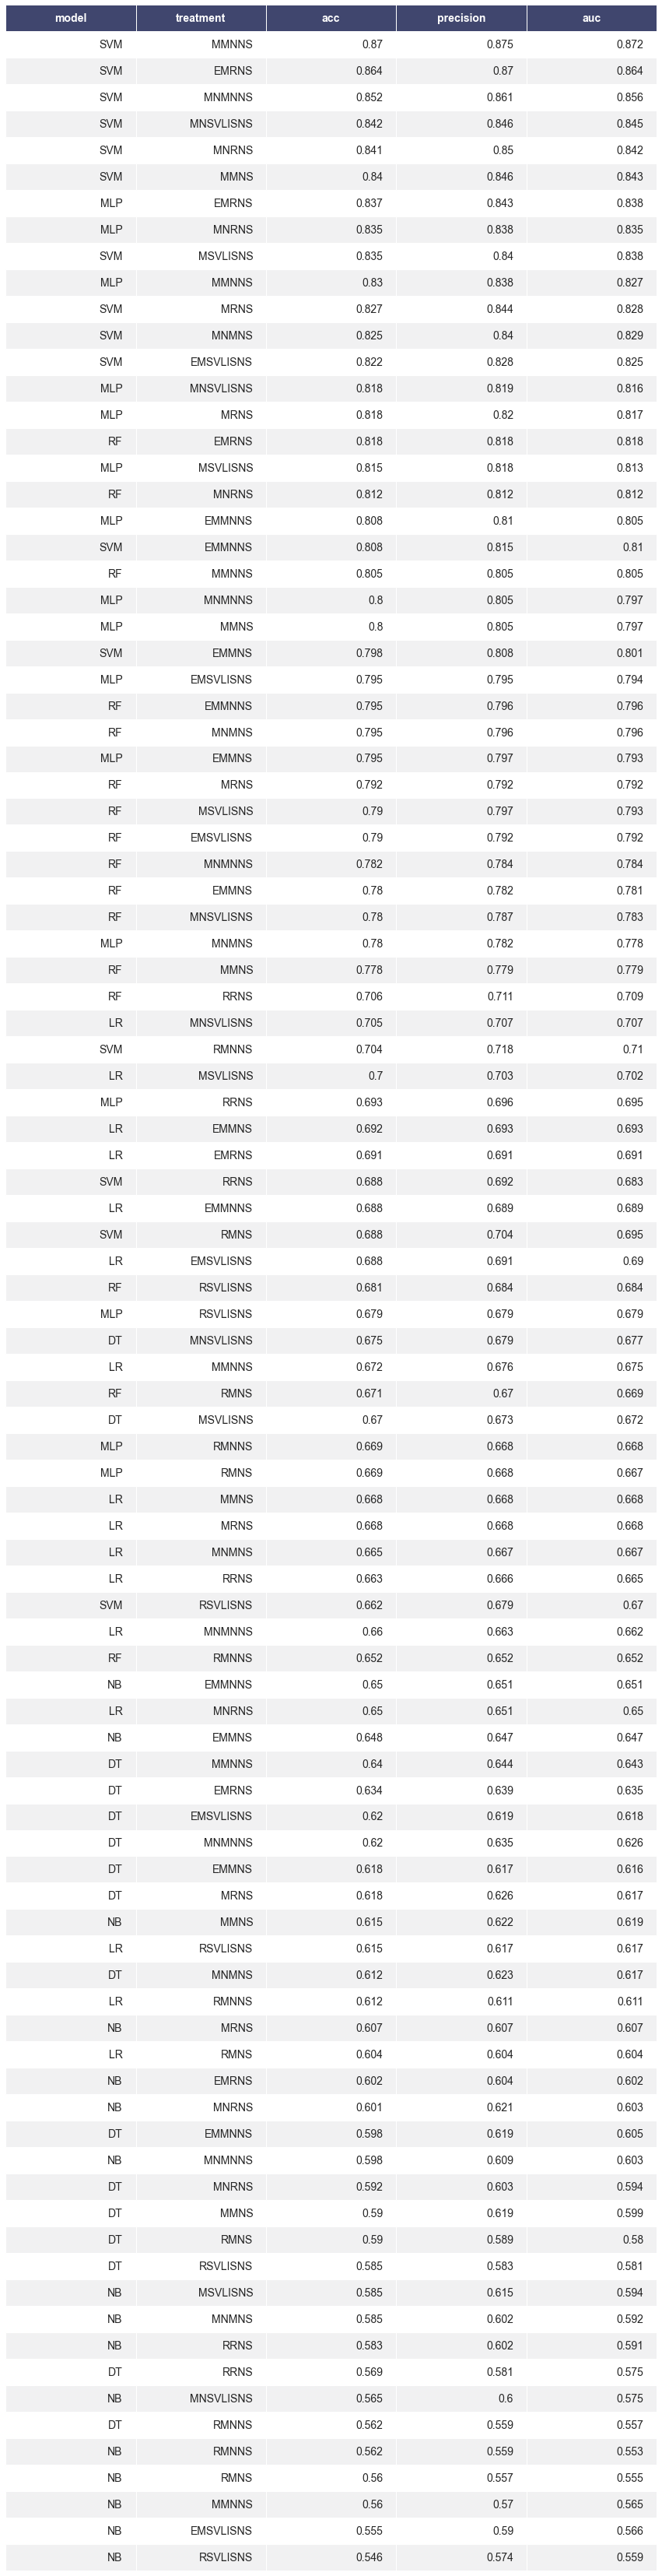

In [61]:
render_mpl_table(df_results_pd.sort_values(by=['acc'], ascending=False))

In [62]:
df_results_svm = df_results_pd[df_results_pd['model'] == 'SVM'].sort_values(by='acc', ascending=False)

In [63]:
df_results_svm

,model,treatment,acc,precision,auc
38,SVM,MMNNS,0.870,0.875,0.872
74,SVM,EMRNS,0.864,0.870,0.864
62,SVM,MNMNNS,0.852,0.861,0.856
68,SVM,MNSVLISNS,0.842,0.846,0.845
50,SVM,MNRNS,0.841,0.850,0.842
32,SVM,MMNS,0.840,0.846,0.843
44,SVM,MSVLISNS,0.835,0.840,0.838
26,SVM,MRNS,0.827,0.844,0.828
56,SVM,MNMNS,0.825,0.840,0.829
92,SVM,EMSVLISNS,0.822,0.828,0.825


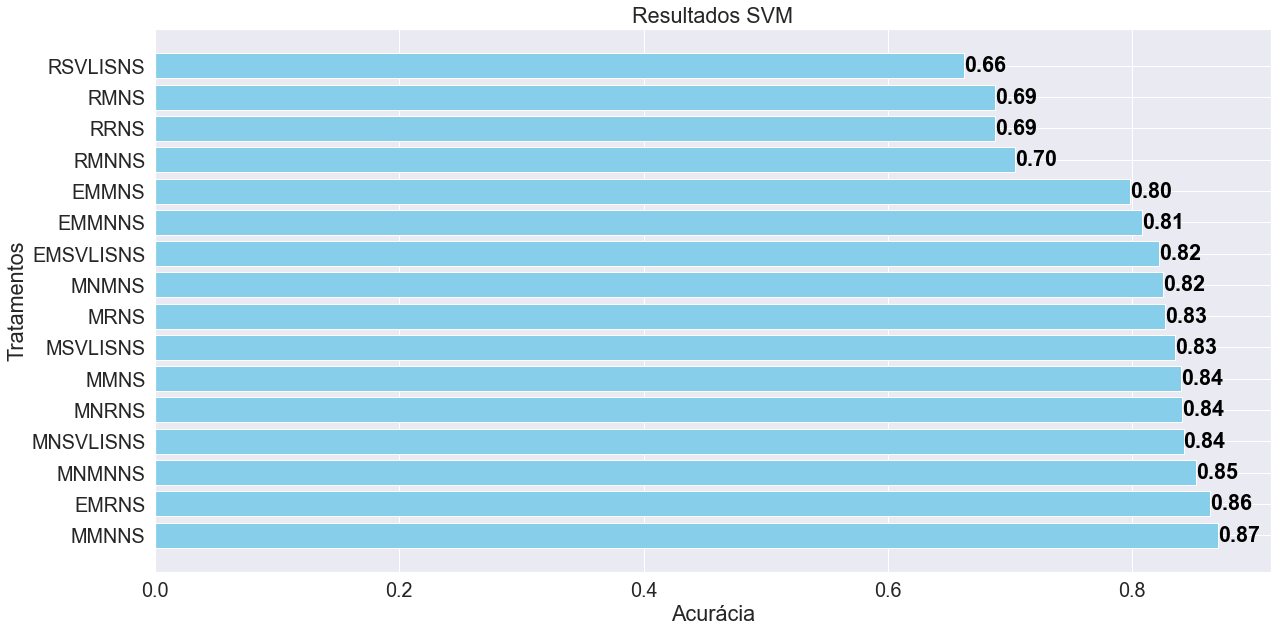

In [64]:
# Criando um exemplo de DataFrame e Ordenando o DataFrame pelos resultados em ordem decrescente
df_results_svm = df_results_pd[df_results_pd['model'] == 'SVM'].sort_values(by='acc', ascending=False)

# Criando o gráfico de barras horizontais
plt.figure(figsize=(20,10))
bars = plt.barh(df_results_svm['treatment'], df_results_svm['acc'], color='skyblue')
plt.xlabel('Acurácia')
plt.ylabel('Tratamentos')
plt.title('Resultados SVM')

# Adicionando os valores ao lado das barras
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='left', color='black', fontweight='bold')

# Exibindo o gráfico
plt.show()